<img src='https://micro.ce.sharif.edu/lib/tpl/writr/images/logo.svg' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Generative Models <br>
<font color=2565AE size=5>
Mathematics & Computer Science department - Fall 2024  <br>
<font color=3C99D size=5>
          Homework 5: Practical - Diffusion models <br>
<font color=696880 size=4>
AmirHossein Haji Mohammad Rezaei, Nasrin Amjadi
    
    
____

# Problem
This assignment uses PyTorch to build and implement a Denoising Diffusion Probabilistic model (DDPM) to learn the distribution of sprites images and evaluate its generated images by using FID score.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image



## hyperparameters


In [ ]:
# diffusion hyperparameters
n_steps = 100
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/content/'

# training hyperparameters
batch_size = 100
n_epoch = 40
lrate=1e-3

## Sprites Dataset

In [ ]:
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy'
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprite_labels_nc_1788_16x16.npy'

--2025-01-26 14:46:06--  https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy
Resolving huggingface.co (huggingface.co)... 3.165.160.59, 3.165.160.61, 3.165.160.11, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/df/b9/dfb98dd9f5f7c221e653770544f82ac8de0044d1f52ab71a1e42ed1a332ae365/61cf3b7e3184f57f2bc2bf5e75fbcf08ba379241f58966c62a9716ef581b2916?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sprites_1788_16x16.npy%3B+filename%3D%22sprites_1788_16x16.npy%22%3B&Expires=1737906367&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNzkwNjM2N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2RmL2I5L2RmYjk4ZGQ5ZjVmN2MyMjFlNjUzNzcwNTQ0ZjgyYWM4ZGUwMDQ0ZDFmNTJhYjcxYTFlNDJlZDFhMzMyYWUzNjUvNjFjZjNiN2UzMTg0ZjU3ZjJiYzJiZj

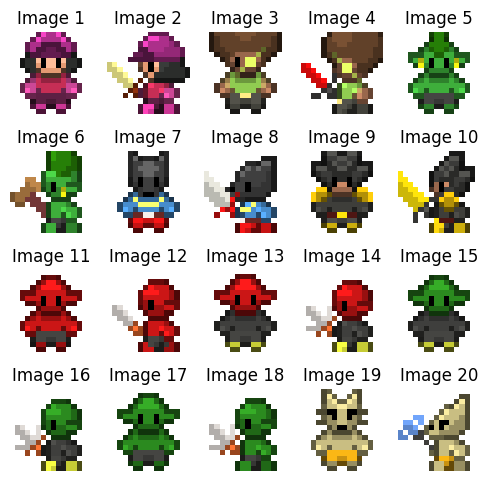

In [ ]:
sprites_samples = np.load("/content/sprites_1788_16x16.npy")[:20]
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()

# Loop through each image and plot it
for i in range(20):
    image = sprites_samples[i]

    # Plot the image in the appropriate subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f'Image {i + 1}')  # Set title

# Hide any unused subplots
for j in range(20, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, _sprites, _slabels, transform, null_context=False):
        self.transform = transform
        self.null_context = null_context
        self.sprites = _sprites
        self.slabels = _slabels
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

In [ ]:
sprites = np.load("/content/sprites_1788_16x16.npy")
slabels = np.load("/content/sprite_labels_nc_1788_16x16.npy")

print(f"sprite shape: {sprites.shape}")
print(f"labels shape: {slabels.shape}")


train_sprites = sprites[:60000]
train_slabels = slabels[:60000]
val_sprites = sprites[60000:]
val_slabels = slabels[60000:]

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [ ]:
# load dataset
trian_dataset = CustomDataset(train_sprites, train_slabels, transform, null_context=False)
train_dataloader = DataLoader(trian_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# load dataset
val_dataset = CustomDataset(val_sprites, val_slabels, transform, null_context=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

## UNet

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

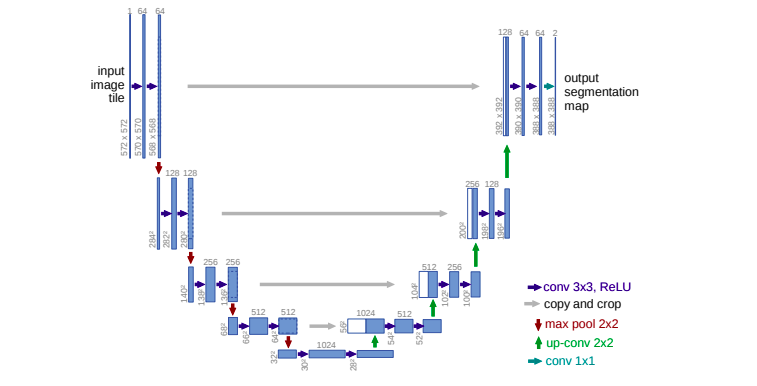

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization , segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(Unet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Training

In [ ]:

nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [ ]:

optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

We want to set up a "**variance schedule**" β, where $\beta_t$ specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. \\
At each time step t, the variance of the noise added to the previous step is predetermined by the variance schedule, and it's marked as $\beta_t$, where 0 < $\beta_1$ < $\beta_t$ < $\beta_2$ < 1.

In [ ]:

timesteps_tensor = torch.linspace(0, 1, timesteps)
beta_t = beta1 + timesteps_tensor * (beta2 - beta1)
beta_t = beta_t.to(device)

### Forward

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


In [ ]:

total_diffusion_steps = 100
noise_schedule = torch.linspace(0.0001, 0.04, total_diffusion_steps).to(device)
signal_preservation = 1. - noise_schedule
cumulative_signal_factors = torch.cumprod(signal_preservation, dim=0).to(device)

def apply_diffusion_step(original_images, diffusion_step):
    if isinstance(diffusion_step, int):
        diffusion_step = torch.tensor([diffusion_step], dtype=torch.long).to(original_images.device)
    elif isinstance(diffusion_step, torch.Tensor):
        diffusion_step = diffusion_step.to(original_images.device)
    current_signal_factor = torch.sqrt(cumulative_signal_factors[diffusion_step]).view(-1, 1, 1, 1)
    current_noise_factor = torch.sqrt(1 - cumulative_signal_factors[diffusion_step]).view(-1, 1, 1, 1)
    gaussian_perturbation = torch.randn_like(original_images).to(original_images.device)
    perturbed_samples = current_signal_factor * original_images + current_noise_factor * gaussian_perturbation

    return perturbed_samples, gaussian_perturbation

### Train Diffsion

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

In [ ]:

model_training_errors = []
model_validation_errors = []
total_cycles = 60
for cycle in range(total_cycles):

    denoising_network.train()
    cycle_training_error = 0.0
    for clean_inputs, _ in training_data_loader:
        clean_inputs = clean_inputs.to(device)
        diffusion_stage = torch.randint(0, total_iterations, (clean_inputs.size(0),)).to(device)
        noisy_observations, true_noise = diffuse_data(clean_inputs, diffusion_stage)
        estimated_noise = denoising_network(noisy_observations, diffusion_stage.unsqueeze(-1).float())
        error_value = F.mse_loss(estimated_noise, true_noise)
        network_optimizer.zero_grad()
        error_value.backward()
        network_optimizer.step()
        cycle_training_error += error_value.item()

    cycle_training_error /= len(training_data_loader)
    model_training_errors.append(cycle_training_error)
    denoising_network.eval()
    cycle_validation_error = 0.0
    with torch.no_grad():
        for clean_inputs, _ in validation_data_loader:
            clean_inputs = clean_inputs.to(device)
            diffusion_stage = torch.randint(0, total_iterations, (clean_inputs.size(0),)).to(device)
            noisy_observations, true_noise = diffuse_data(clean_inputs, diffusion_stage)
            estimated_noise = denoising_network(noisy_observations, diffusion_stage.unsqueeze(-1).float())
            error_value = F.mse_loss(estimated_noise, true_noise)
            cycle_validation_error += error_value.item()

    cycle_validation_error /= len(validation_data_loader)
    model_validation_errors.append(cycle_validation_error)

    print(f"Learning Cycle: {cycle + 1}")
    print(f"Training Set Error : {cycle_training_error}")
    print(f"Validation Set Error : {cycle_validation_error}")

Epoch: 1
Train loss : 0.30952863390247026
Val loss : 0.2380763969960667
Epoch: 2
Train loss : 0.20968453456958136
Val loss : 0.19943935424089432
Epoch: 3
Train loss : 0.18255553190906842
Val loss : 0.17913695019321377
Epoch: 4
Train loss : 0.16621714296440285
Val loss : 0.16613526913483126
Epoch: 5
Train loss : 0.1557189827536543
Val loss : 0.15551666122208646
Epoch: 6
Train loss : 0.14634261172264815
Val loss : 0.14679608410414385
Epoch: 7
Train loss : 0.13962943248450757
Val loss : 0.14165352117650362
Epoch: 8
Train loss : 0.1323514078805844
Val loss : 0.13244792051157173
Epoch: 9
Train loss : 0.12854878244300683
Val loss : 0.13020085310246668
Epoch: 10
Train loss : 0.12329136591404677
Val loss : 0.12164694509234558
Epoch: 11
Train loss : 0.1190925975019733
Val loss : 0.11975589668264194
Epoch: 12
Train loss : 0.11484909120947123
Val loss : 0.11589935495435787
Epoch: 13
Train loss : 0.11263819998751085
Val loss : 0.11252280935442367
Epoch: 14
Train loss : 0.11003148096303145
Val loss

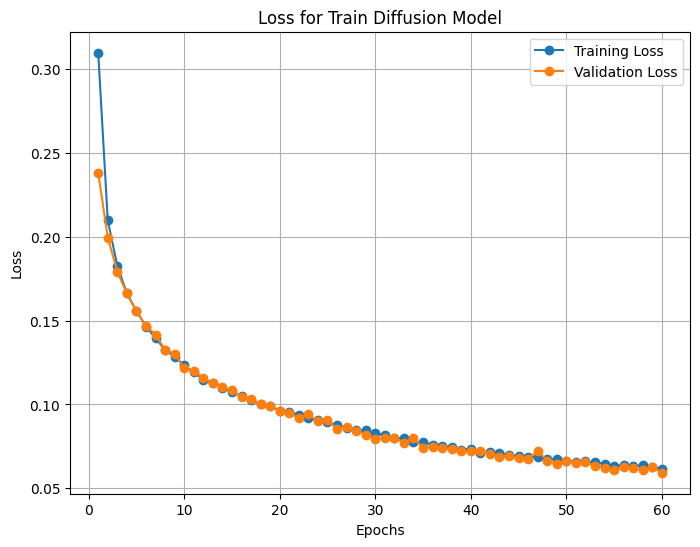

In [ ]:

epochs = list(range(1, n_epochs + 1))

plt.figure(figsize=(8, 6))
plt.plot(epochs, model_training_errors, label="Training Loss", marker="o", linestyle="-")
plt.plot(epochs, model_validation_errors, label="Validation Loss", marker="o", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for Train Diffusion Model")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

model_path = "/content/trained_model.pth"
torch.save(nn_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/trained_model.pth


## Reverse process: DDPM Sampling

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that looks like a real image. \\
Below image show the sampling algorithm

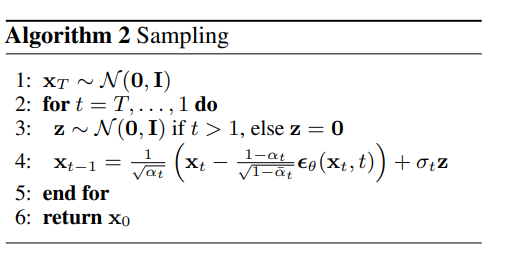

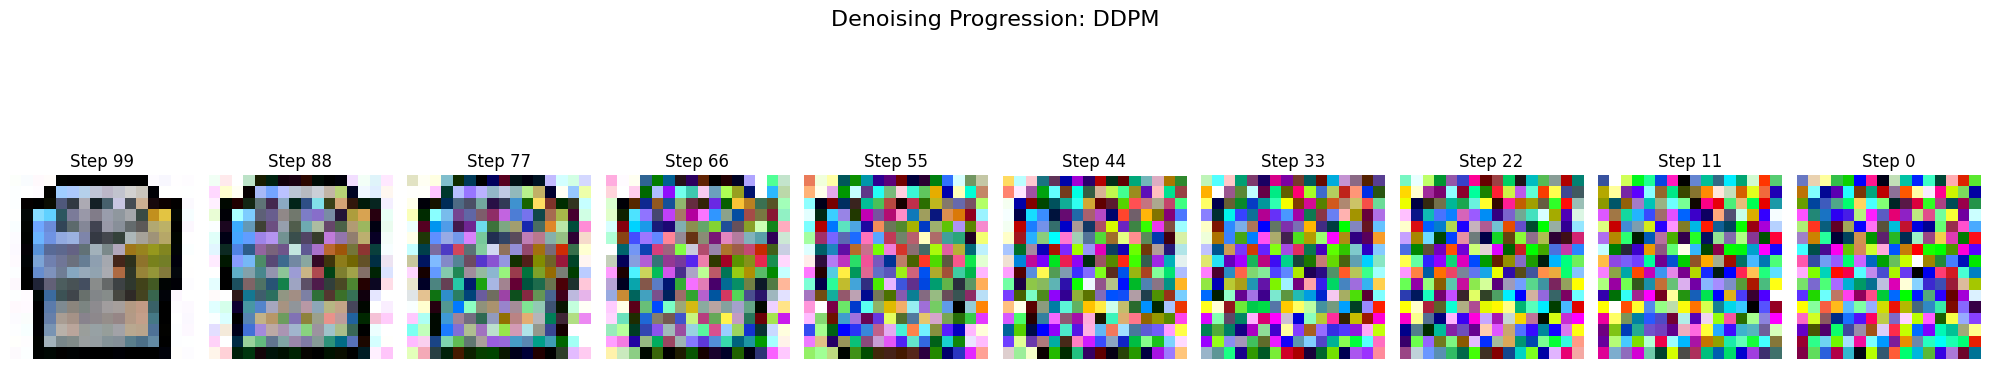

In [ ]:
def reverse_diffusion_step(degraded_sample, model_estimated_noise, diffusion_phase):

    signal_coefficient = signal_preserve[diffusion_phase]
    root_signal = torch.sqrt(signal_coefficient)
    root_noise_variance = torch.sqrt(1 - cumulative_signal[diffusion_phase])
    noise_coefficient = 1 - signal_coefficient

    state_estimate = (1 / root_signal) * (
        degraded_sample - (noise_coefficient / root_noise_variance) * model_estimated_noise
    )

    if diffusion_phase > 0:
        random_perturbation = torch.randn_like(degraded_sample).to(degraded_sample.device)
        deviation = torch.sqrt(noise_coefficient)
        state_estimate += deviation * random_perturbation

    return state_estimate

def generation_procedure(denoising_model, generation_count=5):

    latent_state = torch.randn((generation_count, 3, resolution, resolution)).to(device)

    generation_sequence = [latent_state]

    for reverse_step in range(total_iterations - 1, -1, -1):
        phase_indices = torch.tensor([reverse_step] * generation_count).to(device)
        model_estimated_noise = denoising_model(latent_state, phase_indices.unsqueeze(-1).float())
        latent_state = reverse_diffusion_step(latent_state, model_estimated_noise, reverse_step)
        generation_sequence.append(latent_state)

    return generation_sequence

generated_images = generation_procedure(denoising_network, generation_count=1)

sampled_intervals = np.linspace(total_iterations - 1, 0, num=10, dtype=int)
plot_grid, display_axes = plt.subplots(1, len(sampled_intervals), figsize=(20, 5))

for axis_index, phase in enumerate(sampled_intervals):

    generated_image = generated_images[phase][0]
    display_ready_image = (generated_image.detach().permute(1, 2, 0).cpu().numpy() + 1) / 2
    display_axes[axis_index].imshow(np.clip(display_ready_image, 0, 1))
    display_axes[axis_index].axis("off")
    display_axes[axis_index].set_title(f"Phase {phase}")

plt.suptitle("Image Generation Sequence: Diffusion Model", fontsize=16)
plt.tight_layout()
plt.show()

## Reverse process: DDIM Sampling

Study the DDIM sampling method for reverse process and like the previous part, Implement this process regarding the DDIM method.

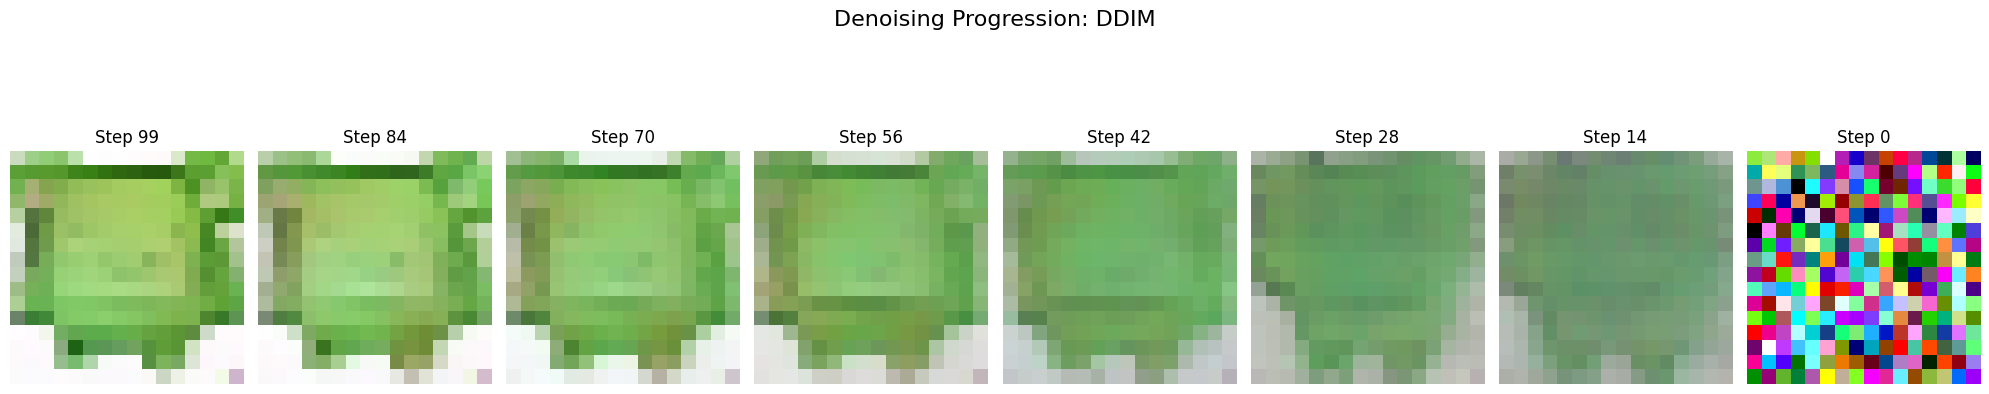

In [ ]:
def stochastic_reversal_step(noisy_observation, network_prediction, process_step, randomness_factor=0.3):
    current_signal_scale = torch.sqrt(cumulative_signal[process_step])
    previous_signal_scale = torch.sqrt(cumulative_signal[process_step-1]) if process_step > 0 else 0
    current_noise_scale = torch.sqrt(1 - cumulative_signal[process_step])
    deterministic_component = (noisy_observation - current_noise_scale * network_prediction) / current_signal_scale

    if process_step > 0:
        random_component = torch.randn_like(noisy_observation).to(noisy_observation.device)
        stochastic_factor = randomness_factor * torch.sqrt(
            (1 - cumulative_signal[process_step-1]) -
            (randomness_factor**2) * (1 - cumulative_signal[process_step])
        )
        reconstructed_state = previous_signal_scale * deterministic_component + stochastic_factor * random_component
    else:
        reconstructed_state = previous_signal_scale * deterministic_component  # Final deterministic step

    return reconstructed_state

def execute_synthesis(denoiser_network, sample_count=5, stochasticity=0.0):

    current_state = torch.randn((sample_count, 3, spatial_dim, spatial_dim)).to(device)
    state_evolution = [current_state]
    for refinement_step in range(total_iterations-1, -1, -1):
        step_indices = torch.tensor([refinement_step]*sample_count).to(device)
        noise_estimate = denoiser_network(current_state, step_indices.unsqueeze(-1).float())
        current_state = stochastic_reversal_step(current_state, noise_estimate, refinement_step, stochasticity)
        state_evolution.append(current_state)

    return state_evolution

ddim_generated_images = execute_synthesis(denoising_network, sample_count=1, stochasticity=0.0)
sampled_phases = np.linspace(total_iterations-1, 0, num=8, dtype=int)
plot_grid, display_axes = plt.subplots(1, len(sampled_phases), figsize=(20,5))

for plot_idx, phase in enumerate(sampled_phases):
    phase_sample = ddim_generated_images[phase][0]
    display_image = (phase_sample.detach().permute(1,2,0).cpu().numpy() + 1) / 2

    display_axes[plot_idx].imshow(np.clip(display_image,0,1))
    display_axes[plot_idx].axis("off")
    display_axes[plot_idx].set_title(f"Phase {phase}")

plt.suptitle("Image Synthesis Sequence: Deterministic Diffusion", fontsize=16)
plt.tight_layout()
plt.show()

## Results

Plot 20 generated images by each of generation processes implemented in the previous part

In [ ]:

nn_model = Unet(in_channels=3, n_feat=64, n_cfeat=5, height=16)
model_path = "/content/trained_model.pth"
nn_model.load_state_dict(torch.load(model_path, map_location=device))
nn_model.to(device)
nn_model.eval()
print("Model loaded successfully!")

<ipython-input-5-c473dc5635f5>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded successfully!


In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)

Generating 20 DDPM samples...
DDPM sample generation completed.
Plotting DDPM generated images...


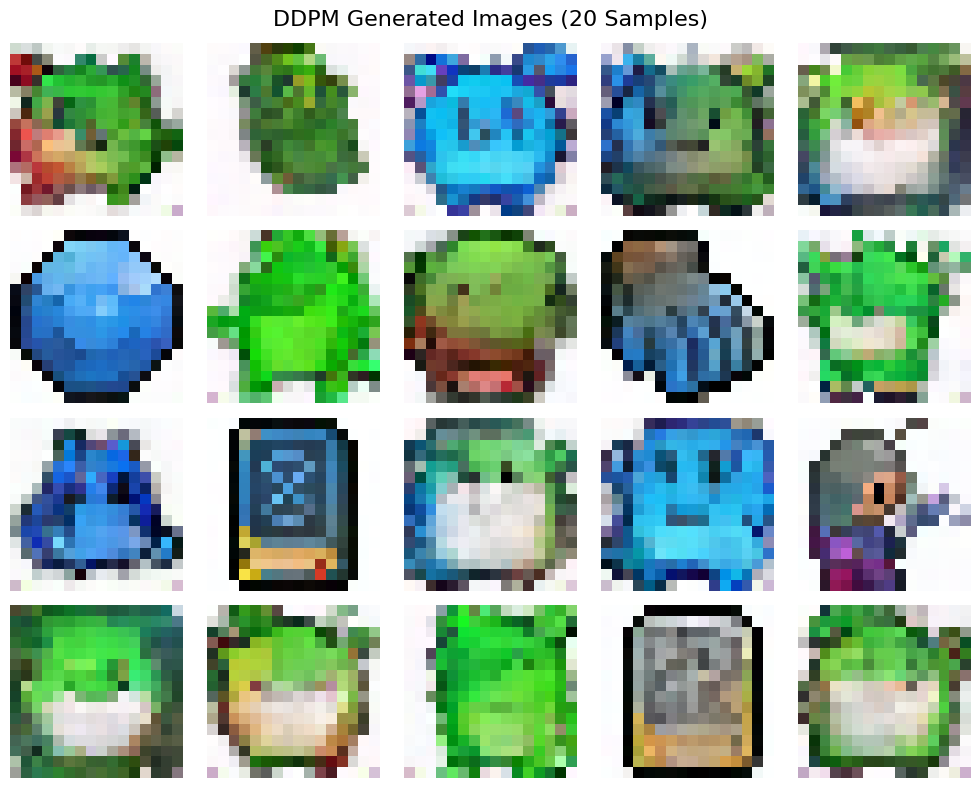

Generating 20 DDIM samples with noise...
DDIM sample generation completed.
Plotting DDIM generated images...


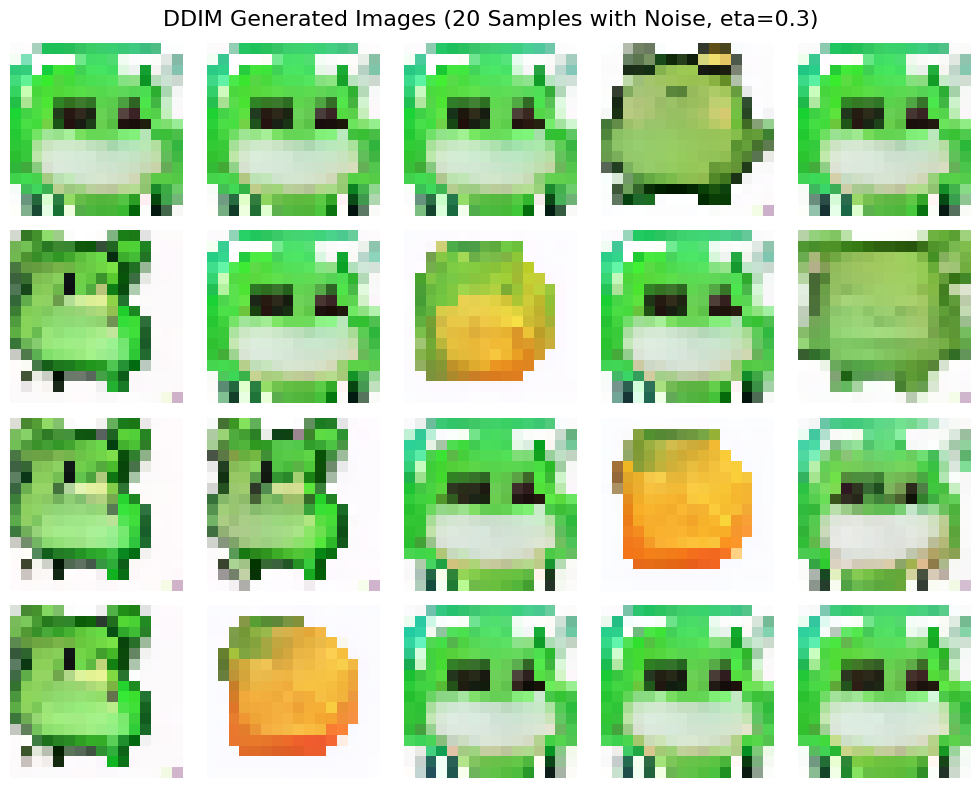

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

def compute_denoised_mean_ddpm(latent_var, model_pred, step_idx):
    alpha_step = alpha[step_idx]
    sqrt_alpha = torch.sqrt(alpha_step).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - alpha_bar[step_idx]).view(-1, 1, 1, 1)
    beta_step = 1 - alpha_step
    denoised_x = (latent_var - (beta_step / sqrt_one_minus_alpha_cumulative) * model_pred) / sqrt_alpha

    if step_idx > 0:
        gaussian_noise = torch.randn_like(latent_var).to(device)
        noise_scale = torch.sqrt(beta_step).view(-1, 1, 1, 1)
        denoised_x += noise_scale * gaussian_noise

    return denoised_x

def compute_ddim_step_with_variance(x_current, model_output, timestep, variance_factor=0.3):

    sqrt_cumulative_alpha = torch.sqrt(alpha_bar[timestep]).view(-1, 1, 1, 1)
    if timestep > 0:
        sqrt_prev_cumulative_alpha = torch.sqrt(alpha_bar[timestep - 1]).view(-1, 1, 1, 1)
    else:
        sqrt_prev_cumulative_alpha = torch.ones_like(sqrt_cumulative_alpha)
    sqrt_one_minus_cumulative_alpha = torch.sqrt(1 - alpha_bar[timestep]).view(-1, 1, 1, 1)

    x0_estimate = (x_current - sqrt_one_minus_cumulative_alpha * model_output) / sqrt_cumulative_alpha

    if timestep > 0:
        random_noise = torch.randn_like(x_current).to(x_current.device)
        noise_magnitude = variance_factor * torch.sqrt(
            (1 - alpha_bar[timestep - 1]) - (variance_factor ** 2) * (1 - alpha_bar[timestep])
        ).view(-1, 1, 1, 1)
        prev_sample = sqrt_prev_cumulative_alpha * x0_estimate + noise_magnitude * random_noise
    else:
        prev_sample = x0_estimate

    return prev_sample


def generate_ddpm_sample(network_model):
    network_model.eval()
    with torch.no_grad():
        current_sample = torch.randn((1, 3, resolution, resolution)).to(device)
        for step in range(total_steps - 1, -1, -1):
            time_tensor = torch.full((1,), step, dtype=torch.long).to(device)
            estimated_noise = network_model(current_sample, time_tensor.unsqueeze(-1).float())
            current_sample = compute_denoised_mean_ddpm(current_sample, estimated_noise, step)
    return current_sample.cpu()

def generate_ddim_sample_variable(network_model, variance_factor=0.3):

    network_model.eval()
    with torch.no_grad():
        current_sample = torch.randn((1, 3, resolution, resolution)).to(device)
        for step in range(total_steps - 1, -1, -1):
            time_tensor = torch.full((1,), step, dtype=torch.long).to(device)
            noise_prediction = network_model(current_sample, time_tensor.unsqueeze(-1).float())
            current_sample = compute_ddim_step_with_variance(
                current_sample, noise_prediction, step, variance_factor
            )
    return current_sample.cpu()


def display_image_grid(samples, title_text, cols=5):
    sample_count = samples.size(0)
    rows = sample_count // cols + int(sample_count % cols > 0)
    plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(sample_count):
        ax = plt.subplot(rows, cols, i + 1)
        img_tensor = samples[i]
        processed_img = (img_tensor.permute(1, 2, 0).numpy() + 1) / 2
        processed_img = np.clip(processed_img, 0, 1)
        ax.imshow(processed_img)
        ax.axis('off')

    plt.suptitle(title_text, fontsize=16)
    plt.tight_layout()
    plt.show()

ddpm_results = []
print("Creating 20 DDPM samples...")
for _ in range(20):
    generated_sample = generate_ddpm_sample(nn_model)
    ddpm_results.append(generated_sample)
ddpm_results = torch.cat(ddpm_results, dim=0)
print("DDPM sampling finished.")

print("Displaying DDPM outputs...")
display_image_grid(ddpm_results, "Generated Images via DDPM (20 Samples)", cols=5)

ddim_results = []
print("Producing 20 DDIM samples with stochastic noise...")
for _ in range(20):
    generated_sample = generate_ddim_sample_variable(nn_model, variance_factor=0.3)
    ddim_results.append(generated_sample)
ddim_results = torch.cat(ddim_results, dim=0)
print("DDIM sampling completed.")

print("Showing DDIM generated images...")
display_image_grid(ddim_results, "DDIM Outputs with Stochastic Sampling (η=0.3)", cols=5)

# Evaluating the Generated Samples:

Now we want to evaluate our model. For this, we use the FID score.

First, read [this link](https://github.com/mseitzer/pytorch-fid) to become familiar with this metric and its usage in your code.

Installation

In [ ]:
!pip install -qq pytorch-fid

Generate 3000 images by your model (by using either of generation processes) and save them in a directory. Also, save 3000 images from the sprites dataset and save them in another directory.

In [ ]:
import os
from torchvision.utils import save_image
from tqdm import tqdm

synth_img_dir = "/content/synthetic_images"
actual_img_dir = "/content/authentic_images"
os.makedirs(synth_img_dir, exist_ok=True)
os.makedirs(actual_img_dir, exist_ok=True)

def store_synthetic_samples(network, sample_count=3000, variance_param=0.3):
    """Produces and persists artificially generated images using DDIM approach"""
    print(f"Creating {sample_count} synthetic images...")
    progress_bar = tqdm(range(sample_count), desc="Synthesizing")
    for idx in progress_bar:
        output_sample = generate_single_sample_ddim_with_noise(network, eta=variance_param)
        save_path = os.path.join(synth_img_dir, f"synth_{idx:04d}.png")
        save_image(output_sample, save_path, normalize=True)

def archive_authentic_images(source_data, max_samples=3000):
    """Preserves ground truth images from original dataset"""
    print(f"Archiving {max_samples} authentic examples...")
    progress_bar = tqdm(range(max_samples), desc="Preserving")
    for counter in progress_bar:
        image_tensor, _ = source_data[counter]
        output_path = os.path.join(actual_img_dir, f"actual_{counter:04d}.png")
        save_image(image_tensor, output_path, normalize=True)
store_synthetic_samples(nn_model, sample_count=3000, variance_param=0.3)
archive_authentic_images(training_dataset, max_samples=3000)

Generating and saving 3000 generated images...


100%|██████████| 3000/3000 [22:19<00:00,  2.24it/s]


Saving 3000 real images...


100%|██████████| 3000/3000 [00:01<00:00, 1569.56it/s]


In [ ]:
import subprocess

reference_dataset_path = "/content/reference_dataset"
synthetic_dataset_path = "/content/synthetic_samples"
print("Evaluating distribution discrepancy...")
metric_calculation = subprocess.run(
    ["pytorch-fid", reference_dataset_path, synthetic_dataset_path],
    capture_output=True,
    text=True
)

print("Fréchet Distance Result:")
distance_value = metric_calculation.stdout
print(distance_value)

Computing FID score...
FID score:
FID:  195.69625097211218

